In [1]:
import sys
import pickle
from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/jupyter/gama/bruno')

from tqdm.notebook import tqdm

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 12


# Data

In [2]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age', model_fname='model_last'):
    best_model_file = wandb.restore(
        model_fname+'.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [14]:
import h5py

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DATASET_FPATH = Path('/home/jupyter/gama/bruno/data/interim/ADNI123_slices_fix_2mm_split_class.hdf5')

class ADNIDataset(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            if self.dataset == 'train+val':
                l = h['train']['y'].shape[0]
                l += h['val']['y'].shape[0]
            else:
                l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        if self.dataset == 'train+val':
            with h5py.File(self._fpath, 'r') as h:
                train_len = h['train']['y'].shape[0]
            index_ = index - train_len

            if index_ < 0:
                dataset = 'train'
            else:
                dataset = 'val'
        else:
            index_ = index
            dataset = self.dataset

        with h5py.File(self._fpath, 'r') as h:
            img = h[dataset]['X'][index_]
            age = h[dataset]['a'][index_]
            label = h[dataset]['y'][index_]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, age, label

h = lambda x: x*25+75

data = ADNIDataset(DATASET_FPATH, dataset='val')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

len(data) / 40

504.0

In [6]:
len(ADNIDataset(DATASET_FPATH, dataset='test')) / 40

770.0

In [7]:
len(ADNIDataset(DATASET_FPATH, dataset='train')) / 40

4719.0

In [64]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '3h05qyn7').to(device)  # efficient-mountain-368
# net = load_from_wandb(net, '18721a16').to(device)  # electric-cherry-345
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

# Threshold tuning

  0%|          | 0/504 [00:00<?, ?it/s]

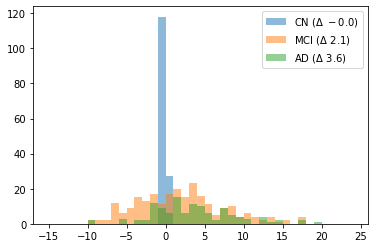

In [46]:
data = ADNIDataset(DATASET_FPATH, dataset='val')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        a_pred = h(net(X.unsqueeze(1).to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

bins = np.arange(-15,25)
plt.hist(age_deltas[groups == 0], bins=bins, alpha=0.5, label=f"CN ($\Delta ~ {age_deltas[groups == 0].mean():.1f}$)")
plt.hist(age_deltas[groups == 3], bins=bins, alpha=0.5, label=f"MCI ($\Delta ~ {age_deltas[groups == 3].mean():.1f}$)")
plt.hist(age_deltas[groups == 4], bins=bins, alpha=0.5, label=f"AD ($\Delta ~ {age_deltas[groups == 4].mean():.1f}$)")
plt.legend()
plt.show()

In [47]:
df = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df.columns = ['Delta', 'Group']
df['Group'] = df['Group'].replace({0:'CN', 3:'MCI', 4:'AD'})
df.groupby('Group').agg([np.mean, np.std])

Delta          
           mean       std
Group                    
AD     3.635426  5.276085
CN    -0.034257  0.033880
MCI    2.061017  5.596952

## AD vs. CN

/opt/conda/envs/bruno/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


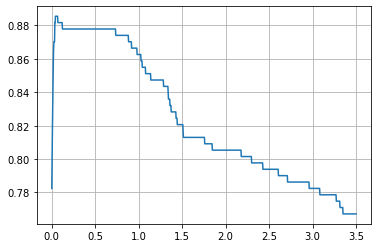

In [49]:
df_adcn = df[df['Group'] != 'MCI']
df_adcn['Label'] = df_adcn['Group'] == 'AD'

thresholds = np.linspace(0, 3.5, 1000)

accs = list()
for thresh in thresholds:
    pred = df_adcn['Delta'] > thresh
    accs.append(sum(pred == df_adcn['Label']) / len(pred))
accs = np.array(accs)

plt.plot(thresholds, accs)
plt.grid()
plt.show()

In [50]:
threshold = thresholds[np.argmax(accs)]
print(f"Best threshold = {threshold:.2f}")

Best threshold = 0.04


# Prediction

In [61]:
threshold = 2.62  # tuned using model trained only on training data
# threshold = 1.00  # tuned using model trained on train+val data

In [65]:
data = ADNIDataset(DATASET_FPATH, dataset='test')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        a_pred = h(net(X.unsqueeze(1).to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

df_test = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df_test.columns = ['Delta', 'Group']
df_test['Group'] = df_test['Group'].replace({0:'CN', 3:'MCI', 4:'AD'})
df_test.groupby('Group').agg([np.mean, np.std])

  0%|          | 0/770 [00:00<?, ?it/s]

Delta          
           mean       std
Group                    
AD     3.745560  5.832286
CN    -0.956460  3.790586
MCI    2.323889  5.493431

In [66]:
df_adcn = df_test[df_test['Group'] != 'MCI']
labels = (df_adcn['Group'] == 'AD')

pred = df_adcn['Delta'] > threshold
acc = sum(pred == labels) / len(pred)

print(f"Test accuracy = {100*acc:.2f}%")
print(f"Test AUC = {roc_auc_score(pred, labels):.2f}")

Test accuracy = 68.21%
Test AUC = 0.68


# Cohen's D

In [113]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

cohen_d(age_deltas[groups == 4], age_deltas[groups == 0])

0.7680749020956529

In [114]:
cohen_d(age_deltas[groups == 3], age_deltas[groups == 0])

0.5414401416499476

In [115]:
cohen_d(age_deltas[groups == 4], age_deltas[groups == 3])

0.16079192157911917